# K-Means clustering from "Scratch"

The k-means clustering algorithm is one of the most basic forms of unsupervised
machine learning, and is foundational to a number of other ML methods.

In this notebook I'll go over the general algorithms, some of the mathematical
intuitions for the methods, and implement a simple "from scratch" function in
python using minimal packages.


## Simple $k$-means clustering by Lloyd's algorithm

The most common practical implementation of $k$-means clustering is an iterative method called Lloyd's algorithm, which is both simple and quick. It does, however, have some drawbacks.

The algorithm is really very straightforward:  
1. Initialize either with $k$ randomly selected points in the $n$-dimensional
   feature space or $k$ randomly selected data points
2. Assign all data points to the nearest of the $k$ selected points/centers
3. Find the centroid of each $k$ assigned cluster

Repeat steps 2 and 3 until the assignments and/or centroids stop changing.

The goal is simple -- find an assignment for all points such that, for each
cluster, the within-cluster data points are closer to the group's centroid than
they are to any other group's center.

So, we basically have five tasks to code:
1. Initialize
2. Distance
3. Assignment
4. Find centers
5. Stopping criteria


### Setup

The only package we'll be using for the algorithm is `numpy`, and we'll generate
some toy data at the end for demonstrations with `sklearn.datasets`. 

In [1]:
import numpy as np

# For demonstration data sets
from sklearn.datasets import make_blobs, make_moons, make_circles
import matplotlib.pyplot as plt

### Initialize $k$ centers

For this example, we'll select $k$ of our data points at random to facilitate
convergence. Alternatively, one could assign $k$ arbitrary points somewhere
within the overall range of the data.

To help randomize the selection, we'll make our random selection with
[`numpy.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)
from a "shuffled" data set using
[`numpy.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html).


In [2]:
def diy_kmeans_initialize(dat, k_clust):

    # Copy the source data array

    dat_shuffled = dat.copy()

    # Shuffle the copy

    np.random.default_rng().shuffle(dat_shuffled, axis=0)

    # Choose k random points from the shuffled matrix

    k_centers = dat_shuffled[np.random.choice(
        dat_shuffled.shape[0], k_clust, replace=False), :]

    return k_centers

### Distance

Find the squared Euclidean distance between each data point and each of the $k$
centers. We'll use `numpy.linalg.norm` to calculate the equivalent square of the
Froebenius or $\ell^2$ matrix norm to generate a matrix $S$ of the squared
distances.

In [3]:
def diy_kmeans_distance(dat, centers):

    S = np.empty((dat.shape[0], centers.shape[0]))

    # Find L2 norm (Euclidean distance) from each center

    for k in range(centers.shape[0]):
        S[:, k] = np.linalg.norm(dat - centers[k, :], axis=1)

    # Return the squared distances

    return np.square(S)

### Assignment

The assignment function is really quite simple, using `numpy.argmin` to return the
index of the smallest row-wise value in the squared distance matrix $S$. 

In [4]:
def diy_kmeans_assign(S):

    # Label by column index of smallest value

    c = np.argmin(S, axis=1)

    return c

### Find new centers

Next we need to find the $k$ new centers by taking the mean of the data points
within each assigned cluster. We'll use a list comprehension and `numpy.mean` to simplify the coding.

In [5]:
def diy_kmeans_update_centers(dat, k_labels):

    # For each cluster label, find the mean of data points indexed by label
    # position for that cluster

    new_k_centers = np.array([np.mean(dat[k_labels == k, :], axis=0)
                             for k in np.unique(k_labels)])

    return new_k_centers

### Stopping criteria

Again, one simple function allows us to detect when the algorithm has converged
to a solution -- `numpy.array_equiv` checks to see if the elements of two arrays
are equivalent. 

For $k$-means, if the centers stop moving then the data point assignments
haven't changed either. We'll use that for our stopping criteria.

In [6]:
def diy_kmeans_converged(old_centers, new_centers):

    # Returns a Boolean value of equivalence

    converged = np.array_equiv(old_centers, new_centers)

    return converged

### Assembling the algorithm

Now, we assemble off of the tasks and implement Lloyd's algorithm for $k$-means
clustering. The function returns a dictionary of the converged clustering
centers and an array of assigned labels. 

In [7]:
def diy_kmeans(dat, n_clusters, max_iter=np.inf):

    # Initial state and iteration counter
    converged = False
    i = 0

    # Initialize centers
    new_centers = diy_kmeans_initialize(dat, n_clusters)

    # Repeat until convergence or maximum iterations reached

    while (not converged) and (i <= max_iter):

        # Update iteration counter
        i += 1

        # Store copy of prior centers
        old_centers = new_centers.copy()

        # Get distances to centers as matrix S
        S = diy_kmeans_distance(dat, new_centers)

        # Assign clusters to matrix C
        C = diy_kmeans_assign(S)

        # Calculate new centers
        new_centers = diy_kmeans_update_centers(dat, C)

        # Status update for "sanity checks" every 10 iterations
        if i % 10 == 0:
            print("Iteration:\t", i)

        # Check stopping criteria
        converged = diy_kmeans_converged(old_centers, new_centers)

    # Convergence notification
    print('Converged in %s iterations.' % i)

    # Create dictionary of labelled cluster centers
    centers = {k: new_centers[k, :] for k in np.unique(C)}
    labels = C

    return centers, labels

## Limitations of $k$-means

The $k$-means algorithm is simple, quick, and effective but it does have its
limitations. 

* It is very sensitive to the initialization step, so can easily converge to a
  sub-optimal *local* minima. There are algorithms other than Lloyd's that try
  to address that sensitivity, but at the cost of time complexity (i.e., they're
  much slower). 
* You need to either make an "educated guess" about the number of clusters or
  run multiple times, using a range of values for $k$, to look for an optimal
  partition
* It works best when clusters are compact, discrete, and linearly separable. If
  there is any overlap between the distributions of each underlying groups or
  there is any non-linearity to the distribution, it will assign within
  arbitrary *linear* boundaries. The underlying intuition behind $k$-means is
  basically a centroidal Voronoi tesselation in $n$-dimensional planes. 
* Since the standard implementations use the $\ell^2$ or Froebenius norm, the
  distance calculation may not be necessarily ideal for higher-dimensional data.

### Demonstration

To demonstrate the algorithm and some cases in which its limitations are
obvious, we'll generate some random data sets with `sklearn.datasets`: 

* Three isotropic Gaussian "blobs" (`make_blobs`)
* Two concentric circles of data points (`make_circles`)
* Two non-linear "moons" of data points (`make_moons`)

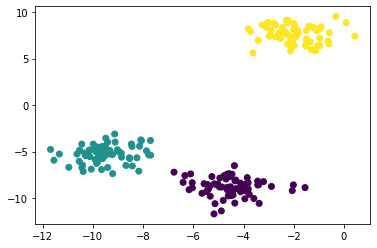

In [8]:
# Isotopic Gaussian clusters

test_blob_data, test_blob_label, test_blob_centers = make_blobs(
    n_samples=200, n_features=2, centers=3, shuffle=True, return_centers=True)

plt.scatter(test_blob_data[:, 0], test_blob_data[:, 1], c=test_blob_label)

Converged in 6 iterations.


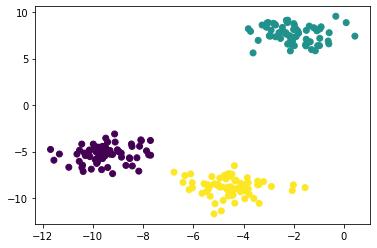

In [9]:
# DIY k-means on blobs

my_blob_ctr, my_blob_label = diy_kmeans(dat=test_blob_data, n_clusters=3)

plt.scatter(test_blob_data[:, 0], test_blob_data[:, 1], c=my_blob_label)

The DIY $k$-means quickly converges to correctly identify the three defined
clusters. As I've intentionally left the random seed open, you will find after
running this a number of times that every once in a while the clusters won't
assign properly. Even with such cleanly delineated groupings as in this "blob"
demonstration data, the random initialization will sometimes result in
converging towards a sub-optimal clustering. 

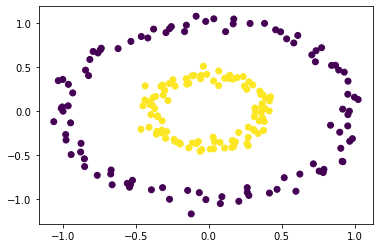

In [10]:
# Concentric circles

test_circ_data, test_circ_label = make_circles(
    n_samples=200, shuffle=True, noise=0.05, factor=0.4)

plt.scatter(test_circ_data[:, 0], test_circ_data[:, 1], c=test_circ_label)

Converged in 8 iterations.


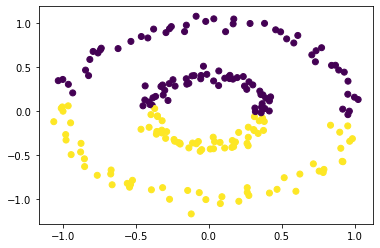

In [11]:
# %% DIY k-means on Circles

my_circ_ctr, my_circ_label = diy_kmeans(dat=test_circ_data, n_clusters=2)

plt.scatter(test_circ_data[:, 0], test_circ_data[:, 1], c=my_circ_label)


The "concentric circles" sample data is one of those cases where $k$-means
cannot identify the obvious. Linear separability and modularity, such as in the
"blob" example, are where $k$-means works the best. In the circles example,
though, one natural group is contained *within* the Euclidean boundary of the
other (alternately stated, the convex hull of one group is completely contained
by the convex hull of the other). 

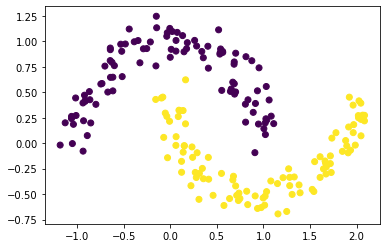

In [12]:
# "Two Moons" data set

test_moons_data, test_moons_label = make_moons(
    n_samples=200, shuffle=True, noise=0.1)

plt.scatter(test_moons_data[:, 0], test_moons_data[:, 1], c=test_moons_label)

Converged in 7 iterations.


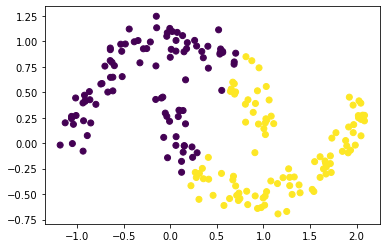

In [13]:
# %% DIY k-means on Moons

my_moons_ctr, my_moons_label = diy_kmeans(dat=test_moons_data, n_clusters=2)

plt.scatter(test_moons_data[:, 0], test_moons_data[:, 1], c=my_moons_label)

The "two moons" sample case is another in which $k$-means will likely fail.
Again, the extent of the one natural group is overlapped or intersected by the
other. The nonlinear boundary throws off the $k$-means distance assignment by
Euclidean or $\ell^2$ norm because the "tail" of one moon is within the "cup"
of the other. 